El objetivo de este notebook es evaluar diferentes combinaciones posibles de los parámetros de Cell-SAM y determinar el más apto para preparar el Dataset.
El análisis se realiza para dos casos, el de imagenes HD (1228x1228) y SD (125x125)

Desempeño cualitativo o de característica de Imagenes SD

2026-01-02 10:03:15,414 [INFO] WRITING LOG OUTPUT TO /home/claudio/.cellpose/run.log
2026-01-02 10:03:15,414 [INFO] 
cellpose version: 	4.0.8 
platform:       	linux 
python version: 	3.10.18 
torch version:  	2.5.1
🔬 Analizando: 12655_0299_1.jpg


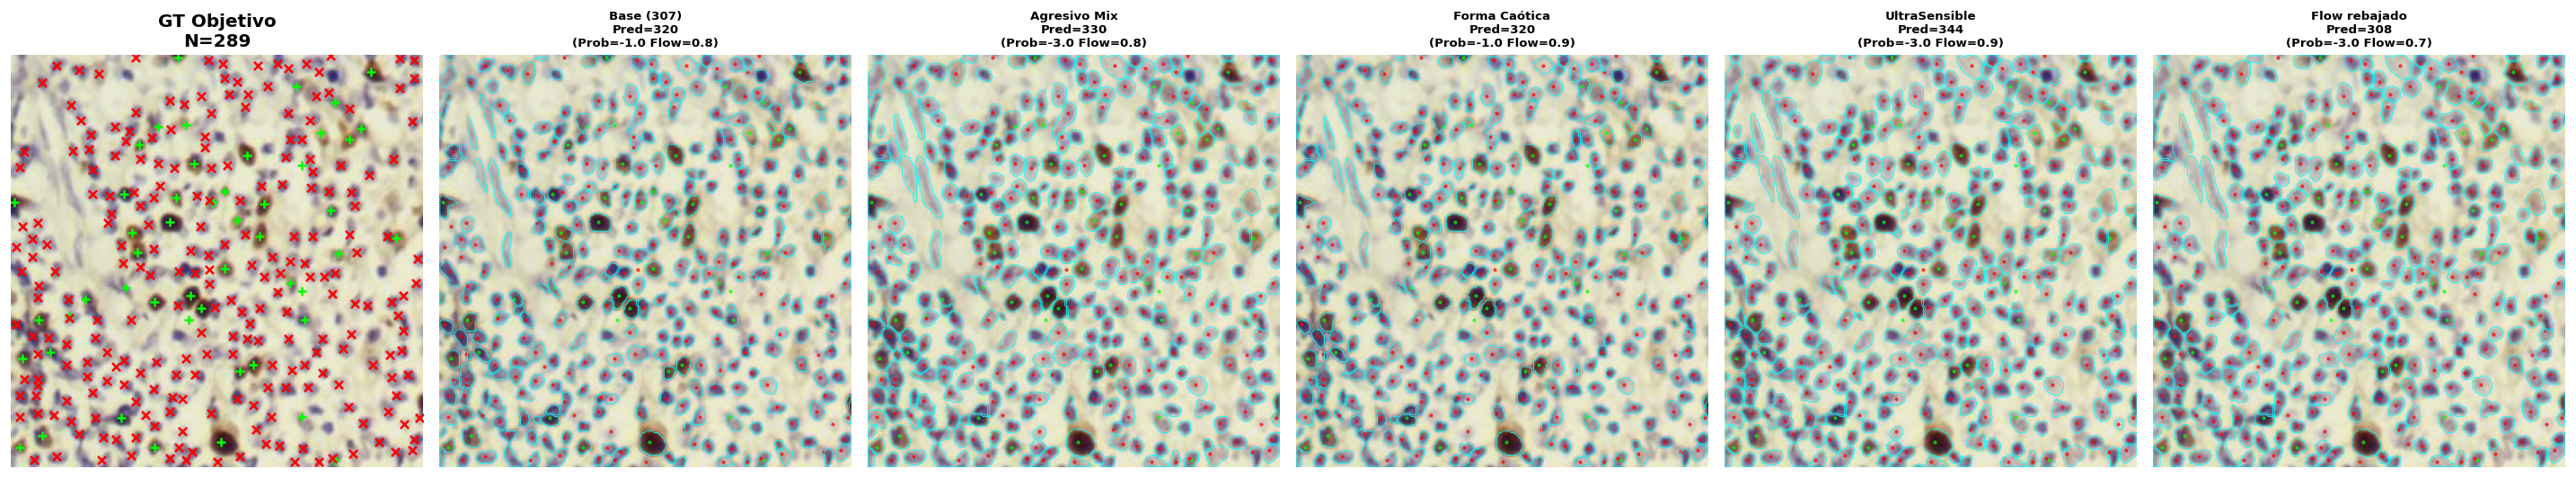

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import warnings
import logging
from pathlib import Path
from glob import glob


from cellpose import models, io, utils

TEST_DIR = Path("/media/HDD2/SHIDC-B-Ki-67/256x256 cropped images/train256")


MODEL_TYPE = 'cpsam'
GPU = True

DIAMETRO_ESTANDAR = 15


CONFIGURACIONES = [
    {'prob': -1.0, 'flow': 0.8, 'min': 7, 'desc': 'Base (307)'},
    {'prob': -3.0, 'flow': 0.8, 'min': 7, 'desc': 'Agresivo Mix'},
    {'prob': -1.0, 'flow': 0.9, 'min': 7, 'desc': 'Forma Caótica'},
    {'prob': -3.0, 'flow': 0.9, 'min': 5,  'desc': 'UltraSensible'},
    {'prob': -3.0, 'flow': 0.7, 'min': 7,  'desc': 'Flow rebajado'},
]



def load_gt_points(img_path):
    """Carga Ground Truth desde JSON (lista o dict)."""
    json_path = img_path.with_suffix('.json')
    if not json_path.exists():
        return [], []
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    

    points_list = data if isinstance(data, list) else list(data.values())[0] if data else []
    
    pos, neg = [], []
    for pt in points_list:
        if pt.get('label_id') == 1: pos.append([pt['x'], pt['y']])
        else: neg.append([pt['x'], pt['y']])
            
    return np.array(pos), np.array(neg)

def visualizar_comparativa(img_path):
    print(f"🔬 Analizando: {img_path.name}")
    

    img = io.imread(str(img_path))
    if img is None: return

    pts_pos, pts_neg = load_gt_points(img_path)
    total_gt = len(pts_pos) + len(pts_neg)
    

    try:

        model = models.CellposeModel(gpu=GPU, pretrained_model=MODEL_TYPE)
    except Exception as e:
        print(f"Error cargando modelo: {e}")
        return


    n_cols = len(CONFIGURACIONES) + 1
    fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 5), dpi=120)
    

    axes[0].imshow(img)
    if len(pts_pos) > 0: axes[0].scatter(pts_pos[:, 0], pts_pos[:, 1], c='lime', marker='+', s=40, linewidths=1.5)
    if len(pts_neg) > 0: axes[0].scatter(pts_neg[:, 0], pts_neg[:, 1], c='red', marker='x', s=30, linewidths=1.5)
    axes[0].set_title(f"GT Objetivo\nN={total_gt}", fontweight='bold')
    axes[0].axis('off')


    for i, config in enumerate(CONFIGURACIONES):
        ax = axes[i + 1]
        

        masks, _, _ = model.eval(img, 
                                 diameter=DIAMETRO_ESTANDAR,
                                 channels=[0,0],
                                 cellprob_threshold=config['prob'],
                                 flow_threshold=config['flow'],
                                 min_size=config['min'])
        
        num_pred = masks.max()
        

        ax.imshow(img)
        

        outlines = utils.outlines_list(masks)
        for o in outlines:
            ax.plot(o[:, 0], o[:, 1], color='cyan', lw=0.5)

        if len(pts_pos) > 0: ax.scatter(pts_pos[:, 0], pts_pos[:, 1], c='lime', marker='.', s=10, alpha=0.6)
        if len(pts_neg) > 0: ax.scatter(pts_neg[:, 0], pts_neg[:, 1], c='red', marker='.', s=10, alpha=0.6)


        title = f"{config['desc']}\nPred={num_pred}"
        subtitle = f"(Prob={config['prob']} Flow={config['flow']})"
        ax.set_title(f"{title}\n{subtitle}", fontsize=8, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    

    del model
    torch.cuda.empty_cache()


io.logger_setup()
logging.getLogger("cellpose").setLevel(logging.CRITICAL)


test_files = sorted(list(TEST_DIR.glob("*.jpg")))

if len(test_files) > 0:

    visualizar_comparativa(test_files[0])
else:
    print(f"No se encontraron imágenes .jpg en {TEST_DIR}")

Desempeño en dataset SD para encontrar nucleos marcados.

In [2]:
import sys
import numpy as np
import pandas as pd
import json
import torch
import warnings
import logging
import cv2
import contextlib
import os
from pathlib import Path
from tqdm.auto import tqdm


from cellpose import models, core, io, utils


BASE_DIR = Path("/media/HDD2/SHIDC-B-Ki-67/256x256 cropped images")
DIRS_TO_PROCESS = [
    BASE_DIR / "train256"
]


CSV_OUTPUT = BASE_DIR / "reporte_metricas_cpsam_refinado.csv"


MODEL_TYPE = 'cpsam'
GPU = True


DIAMETRO_EVAL = 15 


CONFIGURACIONES = [
    {'prob': -1.0, 'flow': 0.8, 'min': 7, 'name': 'Base_Small'},
    {'prob': -3.0, 'flow': 0.9, 'min': 5, 'name': 'UltraSensible_Small'},
]


MAX_IMGS = None 


def load_gt_points(json_path):
    """Carga puntos Ground Truth de manera robusta."""
    if not json_path.exists():
        return []
    
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        points = []

        items = data if isinstance(data, list) else list(data.values())[0] if data else []
        
        for pt in items:
            if 'x' in pt and 'y' in pt:
                points.append([pt['x'], pt['y']])
        return np.array(points)
        
    except Exception as e:
        return []

def calculate_metrics(masks, gt_points):
    """
    Calcula Recall y Falsos Positivos usando pointPolygonTest.
    Retorna: (detectados, perdidos, falsos_positivos, total_gt)
    """
    outlines = utils.outlines_list(masks)
    total_gt = len(gt_points)
    
    gt_detectados_indices = set()
    falsos_positivos = 0
    
    for o in outlines:
        poly = o.astype(np.int32)
        match_found = False
        
        if total_gt > 0:
            for i, point in enumerate(gt_points):

                gx, gy = float(point[0]), float(point[1])
                

                if cv2.pointPolygonTest(poly, (gx, gy), False) >= 0:
                    match_found = True
                    gt_detectados_indices.add(i)
        
        if not match_found:
            falsos_positivos += 1
            
    n_detectados = len(gt_detectados_indices)
    n_perdidos = total_gt - n_detectados
    
    return n_detectados, n_perdidos, falsos_positivos, total_gt



def run_benchmark():

    io.logger_setup()
    logging.getLogger("cellpose").setLevel(logging.CRITICAL)
    warnings.filterwarnings("ignore")
    
    if not core.use_gpu():
        print("⚠️  NO SE DETECTÓ GPU. El proceso será muy lento.")


    all_images = []
    for d in DIRS_TO_PROCESS:
        all_images.extend(sorted(list(d.glob("*.jpg"))))
    

    import random
    random.seed(42)
    random.shuffle(all_images)
    
    if MAX_IMGS and len(all_images) > MAX_IMGS:
        print(f"Dataset recortado a {MAX_IMGS} imágenes aleatorias (de {len(all_images)} totales).")
        all_images = all_images[:MAX_IMGS]
    else:
        print(f"Procesando dataset completo: {len(all_images)} imágenes.")

    print(f"⏳ Cargando modelo {MODEL_TYPE}...")
    try:

        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            model = models.CellposeModel(gpu=GPU, pretrained_model=MODEL_TYPE)
    except Exception as e:
        print(f"Error fatal cargando modelo: {e}")
        return


    resultados = []
    
    pbar = tqdm(all_images, desc="Benchmarking")
    for img_path in pbar:

        img = io.imread(str(img_path)) 
        if img is None: continue
        
        gt_points = load_gt_points(img_path.with_suffix('.json'))
        

        for config in CONFIGURACIONES:
            try:
                # Inferencia Silenciosa
                with open(os.devnull, "w") as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
                    masks, _, _ = model.eval(img, 
                                             diameter=DIAMETRO_EVAL,
                                             channels=[0,0],
                                             invert=True,
                                             cellprob_threshold=config['prob'],
                                             flow_threshold=config['flow'],
                                             min_size=config['min'])
                

                det, lost, fp, total = calculate_metrics(masks, gt_points)
                
                resultados.append({
                    'Imagen': img_path.name,
                    'Configuracion': config['name'],
                    'GT_Detectados_Recall': det,
                    'GT_Perdidos': lost,
                    'Falsos_Positivos_Ruido': fp,
                    'Total_GT': total
                })
                
            except Exception as e:

                pbar.write(f"⚠️ Error en {img_path.name}: {e}")


    if resultados:
        df = pd.DataFrame(resultados)
        df.to_csv(CSV_OUTPUT, index=False)
        print(f"\nReporte guardado en: {CSV_OUTPUT}")
        
        print("\nRESUMEN FINAL (SAM 256px - Diámetro 15):")

        resumen = df.groupby('Configuracion')[['GT_Detectados_Recall', 'GT_Perdidos', 'Falsos_Positivos_Ruido']].sum()
        

        total_preds = resumen['GT_Detectados_Recall'] + resumen['Falsos_Positivos_Ruido']
        resumen['Precision_Aprox_%'] = (resumen['GT_Detectados_Recall'] / total_preds * 100).fillna(0).round(2)
        

        total_gt_global = resumen['GT_Detectados_Recall'] + resumen['GT_Perdidos']
        resumen['Recall_Global_%'] = (resumen['GT_Detectados_Recall'] / total_gt_global * 100).fillna(0).round(2)


        print(resumen.sort_values(by='GT_Detectados_Recall', ascending=False))
    else:
        print("No se generaron resultados.")

if __name__ == "__main__":
    run_benchmark()

📂  Procesando dataset completo: 1656 imágenes.
⏳ Cargando modelo cpsam...


Benchmarking:   0%|          | 0/1656 [00:00<?, ?it/s]


✅ Reporte guardado en: /media/HDD2/SHIDC-B-Ki-67/256x256 cropped images/reporte_metricas_cpsam_refinado.csv

📊 RESUMEN FINAL (SAM 256px - Diámetro 15):
                     GT_Detectados_Recall  GT_Perdidos  \
Configuracion                                            
UltraSensible_Small                109461         3767   
Base_Small                         103770         9458   

                     Falsos_Positivos_Ruido  Precision_Aprox_%  \
Configuracion                                                    
UltraSensible_Small                  108565              50.21   
Base_Small                            83196              55.50   

                     Recall_Global_%  
Configuracion                         
UltraSensible_Small            96.67  
Base_Small                     91.65  


Desempeño cualitativo o de característica de Imagenes HD

⚠️ NO SE ENCONTRÓ: p1_0299_1.jpg
   Buscando alternativas en la carpeta...
   🔄 Usando la primera disponible: p10_0031_5.jpg
🔬 Analizando: p10_0031_5.jpg


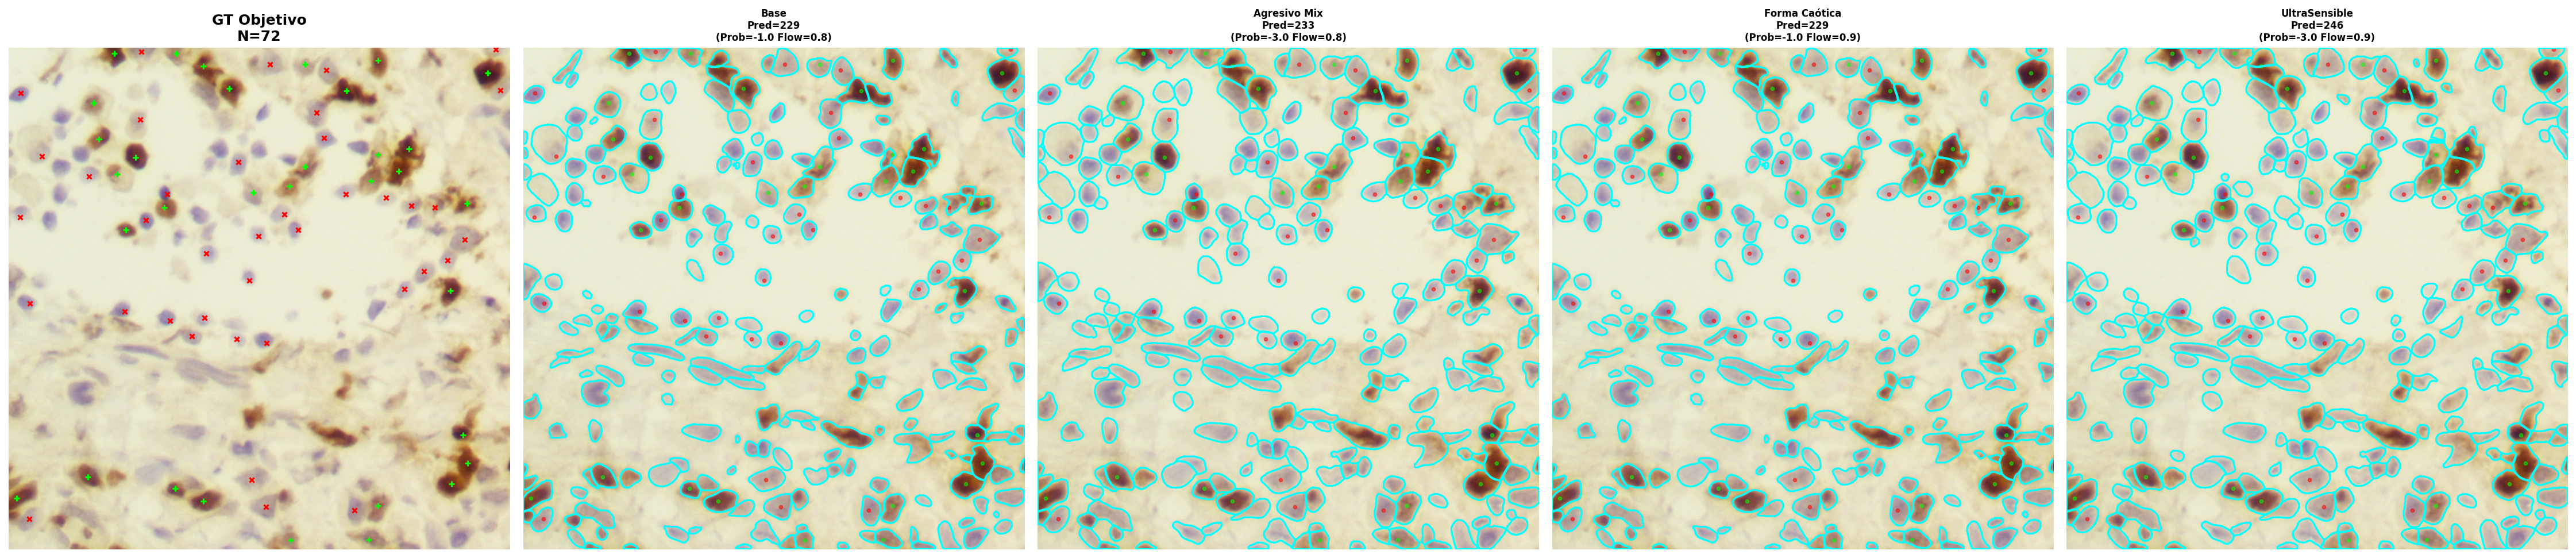

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import warnings
import logging
from pathlib import Path
from glob import glob


from cellpose import models, io, utils


TEST_DIR = Path("/media/HDD2/SHIDC-B-Ki-67/bare images/Train")
SELECTED_FILENAME = "p1_0299_1.jpg"

MODEL_TYPE = 'cpsam'
GPU = True

DIAMETRO_ESTANDAR = 72

CONFIGURACIONES = [
    {'prob': -1.0, 'flow': 0.8, 'min': 30, 'desc': 'Base'},
    {'prob': -3.0, 'flow': 0.8, 'min': 30, 'desc': 'Agresivo Mix'},
    {'prob': -1.0, 'flow': 0.9, 'min': 30, 'desc': 'Forma Caótica'},
    {'prob': -3.0, 'flow': 0.9, 'min': 25,  'desc': 'UltraSensible'},
]


def load_gt_points(img_path):
    """Carga Ground Truth desde JSON (lista o dict)."""
    json_path = img_path.with_suffix('.json')
    if not json_path.exists():
        return [], []
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    

    points_list = data if isinstance(data, list) else list(data.values())[0] if data else []
    
    pos, neg = [], []
    for pt in points_list:
        if pt.get('label_id') == 1: pos.append([pt['x'], pt['y']])
        else: neg.append([pt['x'], pt['y']])
            
    return np.array(pos), np.array(neg)

def visualizar_comparativa(img_path):
    print(f"🔬 Analizando: {img_path.name}")
    
    img = io.imread(str(img_path))
    if img is None: return

    pts_pos, pts_neg = load_gt_points(img_path)
    total_gt = len(pts_pos) + len(pts_neg)
    
    try:

        model = models.CellposeModel(gpu=GPU, pretrained_model=MODEL_TYPE)
    except Exception as e:
        print(f"Error cargando modelo: {e}")
        return


    n_cols = len(CONFIGURACIONES) + 1
    fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 7), dpi=150)
    

    axes[0].imshow(img)
    if len(pts_pos) > 0: axes[0].scatter(pts_pos[:, 0], pts_pos[:, 1], c='lime', marker='+', s=20, linewidths=1.5)
    if len(pts_neg) > 0: axes[0].scatter(pts_neg[:, 0], pts_neg[:, 1], c='red', marker='x', s=15, linewidths=1.5)
    axes[0].set_title(f"GT Objetivo\nN={total_gt}", fontweight='bold')
    axes[0].axis('off')


    for i, config in enumerate(CONFIGURACIONES):
        ax = axes[i + 1]
        

        masks, _, _ = model.eval(img, 
                                 diameter=DIAMETRO_ESTANDAR,
                                 cellprob_threshold=config['prob'],
                                 flow_threshold=config['flow'],
                                 min_size=config['min'])
        
        num_pred = masks.max()
        

        ax.imshow(img)
        

        outlines = utils.outlines_list(masks)
        for o in outlines:
            ax.plot(o[:, 0], o[:, 1], color='cyan', lw=1.5)
            

        if len(pts_pos) > 0: ax.scatter(pts_pos[:, 0], pts_pos[:, 1], c='lime', marker='.', s=30, alpha=0.5)
        if len(pts_neg) > 0: ax.scatter(pts_neg[:, 0], pts_neg[:, 1], c='red', marker='.', s=30, alpha=0.5)


        title = f"{config['desc']}\nPred={num_pred}"
        subtitle = f"(Prob={config['prob']} Flow={config['flow']})"
        ax.set_title(f"{title}\n{subtitle}", fontsize=8, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    del model
    torch.cuda.empty_cache()

target_path = TEST_DIR / SELECTED_FILENAME

if target_path.exists():
    print(f"Imagen objetivo encontrada: {SELECTED_FILENAME}")
    visualizar_comparativa(target_path)
else:
    print(f"NO SE ENCONTRÓ: {SELECTED_FILENAME}")
    print("   Buscando alternativas en la carpeta...")
    
    test_files = sorted(list(TEST_DIR.glob("*.jpg")))
    if len(test_files) > 0:
        print(f"Usando la primera disponible: {test_files[0].name}")
        visualizar_comparativa(test_files[0])
    else:
        print(f"No hay imágenes .jpg en {TEST_DIR}")

Desempeño en dataset HD para encontrar nucleos marcados.

In [4]:
import sys
import numpy as np
import pandas as pd
import json
import torch
import warnings
import logging
import cv2
import contextlib
import os
from pathlib import Path
from tqdm.auto import tqdm


from cellpose import models, core, io, utils

BASE_DIR = Path("/media/HDD2/SHIDC-B-Ki-67/bare images")
DIRS_TO_PROCESS = [
    BASE_DIR / "Train"
]


CSV_OUTPUT = BASE_DIR / "reporte_metricas_cpsam_HD_refinado.csv"

MODEL_TYPE = 'cpsam'
GPU = True

DIAMETRO_EVAL = 72

CONFIGURACIONES = [
    {'prob': -1.0, 'flow': 0.8, 'min': 30, 'name': 'Base'},
    {'prob': -3.0, 'flow': 0.9, 'min': 25,  'name': 'UltraSensible'},
]

MAX_IMGS = None 


def load_gt_points(json_path):
    """Carga puntos Ground Truth de manera robusta."""
    if not json_path.exists():
        return []
    
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        points = []
        items = data if isinstance(data, list) else list(data.values())[0] if data else []
        
        for pt in items:
            if 'x' in pt and 'y' in pt:
                points.append([pt['x'], pt['y']])
        return np.array(points)
        
    except Exception as e:
        return []

def calculate_metrics(masks, gt_points):
    """
    Calcula Recall y Falsos Positivos usando pointPolygonTest.
    Retorna: (detectados, perdidos, falsos_positivos, total_gt)
    """
    outlines = utils.outlines_list(masks)
    total_gt = len(gt_points)
    
    gt_detectados_indices = set()
    falsos_positivos = 0
    
    for o in outlines:
        poly = o.astype(np.int32)
        match_found = False
        
        if total_gt > 0:
            for i, point in enumerate(gt_points):
                gx, gy = float(point[0]), float(point[1])
                
                if cv2.pointPolygonTest(poly, (gx, gy), False) >= 0:
                    match_found = True
                    gt_detectados_indices.add(i)
        
        if not match_found:
            falsos_positivos += 1
            
    n_detectados = len(gt_detectados_indices)
    n_perdidos = total_gt - n_detectados
    
    return n_detectados, n_perdidos, falsos_positivos, total_gt


def run_benchmark():
    io.logger_setup()
    logging.getLogger("cellpose").setLevel(logging.CRITICAL)
    warnings.filterwarnings("ignore")
    
    if not core.use_gpu():
        print("⚠️  NO SE DETECTÓ GPU. El proceso será muy lento.")

    all_images = []
    for d in DIRS_TO_PROCESS:
        all_images.extend(sorted(list(d.glob("*.jpg"))))

    import random
    random.seed(42)
    random.shuffle(all_images)
    
    if MAX_IMGS and len(all_images) > MAX_IMGS:
        print(f"Dataset recortado a {MAX_IMGS} imágenes aleatorias (de {len(all_images)} totales).")
        all_images = all_images[:MAX_IMGS]
    else:
        print(f"Procesando dataset completo: {len(all_images)} imágenes.")


    print(f"Cargando modelo {MODEL_TYPE}...")
    try:

        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            model = models.CellposeModel(gpu=GPU, pretrained_model=MODEL_TYPE)
    except Exception as e:
        print(f"Error fatal cargando modelo: {e}")
        return


    resultados = []
    
    pbar = tqdm(all_images, desc="Benchmarking")
    for img_path in pbar:
        img = io.imread(str(img_path)) 
        if img is None: continue
        
        gt_points = load_gt_points(img_path.with_suffix('.json'))
        

        for config in CONFIGURACIONES:
            try:

                with open(os.devnull, "w") as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
                    masks, _, _ = model.eval(img, 
                                             diameter=DIAMETRO_EVAL,
                                             invert=True,
                                             cellprob_threshold=config['prob'],
                                             flow_threshold=config['flow'],
                                             min_size=config['min'])
                
                det, lost, fp, total = calculate_metrics(masks, gt_points)
                
                resultados.append({
                    'Imagen': img_path.name,
                    'Configuracion': config['name'],
                    'GT_Detectados_Recall': det,
                    'GT_Perdidos': lost,
                    'Falsos_Positivos_Ruido': fp,
                    'Total_GT': total
                })
                
            except Exception as e:
                pbar.write(f"Error en {img_path.name}: {e}")

    if resultados:
        df = pd.DataFrame(resultados)
        df.to_csv(CSV_OUTPUT, index=False)
        print(f"\nReporte guardado en: {CSV_OUTPUT}")
        
        print("\nRESUMEN FINAL (SAM 1228px - Diámetro 72):")

        resumen = df.groupby('Configuracion')[['GT_Detectados_Recall', 'GT_Perdidos', 'Falsos_Positivos_Ruido']].sum()
        
        total_preds = resumen['GT_Detectados_Recall'] + resumen['Falsos_Positivos_Ruido']
        resumen['Precision_Aprox_%'] = (resumen['GT_Detectados_Recall'] / total_preds * 100).fillna(0).round(2)
        
        total_gt_global = resumen['GT_Detectados_Recall'] + resumen['GT_Perdidos']
        resumen['Recall_Global_%'] = (resumen['GT_Detectados_Recall'] / total_gt_global * 100).fillna(0).round(2)

        print(resumen.sort_values(by='GT_Detectados_Recall', ascending=False))
    else:
        print("No se generaron resultados.")

if __name__ == "__main__":
    run_benchmark()

📂  Procesando dataset completo: 1656 imágenes.
⏳ Cargando modelo cpsam...


Benchmarking:   0%|          | 0/1656 [00:00<?, ?it/s]


✅ Reporte guardado en: /media/HDD2/SHIDC-B-Ki-67/bare images/reporte_metricas_cpsam_HD_refinado.csv

📊 RESUMEN FINAL (SAM 1228px - Diámetro 72):
               GT_Detectados_Recall  GT_Perdidos  Falsos_Positivos_Ruido  \
Configuracion                                                              
UltraSensible                112363          865                  190085   
Base                         110800         2428                  161426   

               Precision_Aprox_%  Recall_Global_%  
Configuracion                                      
UltraSensible              37.15            99.24  
Base                       40.70            97.86  


Desempeño de BCData y cellpose SAM HD

In [7]:
import sys
import numpy as np
import pandas as pd
import h5py
import torch
import warnings
import logging
import cv2
import contextlib
import os
from pathlib import Path
from tqdm.auto import tqdm


from cellpose import models, core, io, utils

BASE_ROOT = Path("/media/HDD2/BCData/BCData")
IMG_DIR = BASE_ROOT / "images/train"
GT_POS_DIR = BASE_ROOT / "annotations/train/positive"
GT_NEG_DIR = BASE_ROOT / "annotations/train/negative"


CSV_OUTPUT = BASE_ROOT / "reporte_metricas_cpsam_BCData_Diam47.csv"


MODEL_TYPE = 'cpsam'
GPU = True


DIAMETRO_EVAL = 47

CONFIGURACIONES = [
    {'prob': 0.0,  'flow': 0.4, 'min': 20, 'name': 'Standard'},
    {'prob': -1.0, 'flow': 0.8, 'min': 20, 'name': 'Sensible'},
    {'prob': -3.0, 'flow': 0.9, 'min': 20,  'name': 'Ultra Sensible'},
]


MAX_IMGS = None 


def load_gt_points_bcdata(img_stem):
    """
    Carga y combina los puntos positivos y negativos desde los .h5 de BCData.
    Retorna un array numpy (N, 2).
    """
    points_list = []
    
    h5_name = f"{img_stem}.h5"
    
    paths_to_check = [GT_POS_DIR / h5_name, GT_NEG_DIR / h5_name]
    
    for p in paths_to_check:
        if p.exists():
            try:
                with h5py.File(p, 'r') as f:
                    
                    if 'coordinates' in f.keys():
                        data = f['coordinates'][:]
                        if data.size > 0:
                            points_list.append(data)
                    elif 'coordinate' in f.keys():
                        data = f['coordinate'][:]
                        if data.size > 0:
                            points_list.append(data)
            except Exception as e:
                pass 
    
    if not points_list:
        return np.array([])

    return np.vstack(points_list)

def calculate_metrics(masks, gt_points):
    """
    Calcula Recall y Falsos Positivos usando pointPolygonTest.
    """
    if len(gt_points) == 0:
        outlines = utils.outlines_list(masks)
        return 0, 0, len(outlines), 0

    outlines = utils.outlines_list(masks)
    total_gt = len(gt_points)
    
    gt_detectados_indices = set()
    falsos_positivos = 0
    
    for o in outlines:
        poly = o.astype(np.int32)
        match_found = False
        
        for i, point in enumerate(gt_points):
            gx, gy = float(point[0]), float(point[1])
            
            if cv2.pointPolygonTest(poly, (gx, gy), False) >= 0:
                match_found = True
                gt_detectados_indices.add(i)
        
        if not match_found:
            falsos_positivos += 1
            
    n_detectados = len(gt_detectados_indices)
    n_perdidos = total_gt - n_detectados
    
    return n_detectados, n_perdidos, falsos_positivos, total_gt


def run_benchmark():
    io.logger_setup()
    logging.getLogger("cellpose").setLevel(logging.CRITICAL)
    warnings.filterwarnings("ignore")
    
    if not core.use_gpu():
        print("NO SE DETECTÓ GPU. El proceso será muy lento.")

    img_files = sorted(list(IMG_DIR.glob("*.png"))) 
    if not img_files:
        img_files = sorted(list(IMG_DIR.glob("*.jpg")))
        
    if not img_files:
        print(f"No se encontraron imágenes en {IMG_DIR}")
        return

    import random
    random.seed(42)
    random.shuffle(img_files)
    
    if MAX_IMGS and len(img_files) > MAX_IMGS:
        print(f"Dataset recortado a {MAX_IMGS} imágenes (de {len(img_files)}).")
        img_files = img_files[:MAX_IMGS]
    else:
        print(f"Procesando dataset BCData completo: {len(img_files)} imágenes.")

    print(f"Cargando modelo {MODEL_TYPE}...")
    try:
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
            model = models.CellposeModel(gpu=GPU, pretrained_model=MODEL_TYPE)
    except Exception as e:
        print(f"Error fatal cargando modelo: {e}")
        return

    resultados = []
    
    pbar = tqdm(img_files, desc=f"Benchmarking (Diam={DIAMETRO_EVAL})")
    for img_path in pbar:
        img = io.imread(str(img_path))
        if img is None: continue
        
        gt_points = load_gt_points_bcdata(img_path.stem)
        
        for config in CONFIGURACIONES:
            try:
                with open(os.devnull, "w") as f, contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
                    masks, _, _ = model.eval(img, 
                                             diameter=DIAMETRO_EVAL,
                                             invert=True, 
                                             cellprob_threshold=config['prob'],
                                             flow_threshold=config['flow'],
                                             min_size=config['min'])
                
                det, lost, fp, total = calculate_metrics(masks, gt_points)
                
                resultados.append({
                    'Imagen': img_path.name,
                    'Configuracion': config['name'],
                    'GT_Detectados_Recall': det,
                    'GT_Perdidos': lost,
                    'Falsos_Positivos_Ruido': fp,
                    'Total_GT': total
                })
                
            except Exception as e:
                pbar.write(f"Error en {img_path.name}: {e}")

    if resultados:
        df = pd.DataFrame(resultados)
        df.to_csv(CSV_OUTPUT, index=False)
        print(f"\nReporte guardado en: {CSV_OUTPUT}")
        
        print(f"\nRESUMEN FINAL (BCData - Diametro {DIAMETRO_EVAL}):")
        
        resumen = df.groupby('Configuracion')[['GT_Detectados_Recall', 'GT_Perdidos', 'Falsos_Positivos_Ruido']].sum()
        
        total_predicciones = resumen['GT_Detectados_Recall'] + resumen['Falsos_Positivos_Ruido']
        resumen['Precision_Aprox_%'] = (resumen['GT_Detectados_Recall'] / total_predicciones * 100).fillna(0).round(2)
        
        total_real = resumen['GT_Detectados_Recall'] + resumen['GT_Perdidos']
        resumen['Recall_Global_%'] = (resumen['GT_Detectados_Recall'] / total_real * 100).fillna(0).round(2)

        prec = resumen['Precision_Aprox_%'] / 100
        rec = resumen['Recall_Global_%'] / 100
        resumen['F1_Score'] = (2 * prec * rec / (prec + rec)).fillna(0).round(4)

        print(resumen.sort_values(by='F1_Score', ascending=False))
    else:
        print("No se generaron resultados.")

if __name__ == "__main__":
    run_benchmark()

📂  Procesando dataset BCData completo: 803 imágenes.
⏳ Cargando modelo cpsam...


Benchmarking (Diam=47):   0%|          | 0/803 [00:00<?, ?it/s]


✅ Reporte guardado en: /media/HDD2/BCData/BCData/reporte_metricas_cpsam_BCData_Diam47.csv

📊 RESUMEN FINAL (BCData - Diametro 47):
                GT_Detectados_Recall  GT_Perdidos  Falsos_Positivos_Ruido  \
Configuracion                                                               
Standard                       84137         9701                   40849   
Sensible                       88184         5654                   50077   
Ultra Sensible                 90966         2872                   57100   

                Precision_Aprox_%  Recall_Global_%  F1_Score  
Configuracion                                                 
Standard                    67.32            89.66    0.7690  
Sensible                    63.78            93.97    0.7599  
Ultra Sensible              61.44            96.94    0.7521  


Comparacion Cualitativa BCData

🎯 Imagen objetivo encontrada: 0.png
🔬 Analizando: 0.png


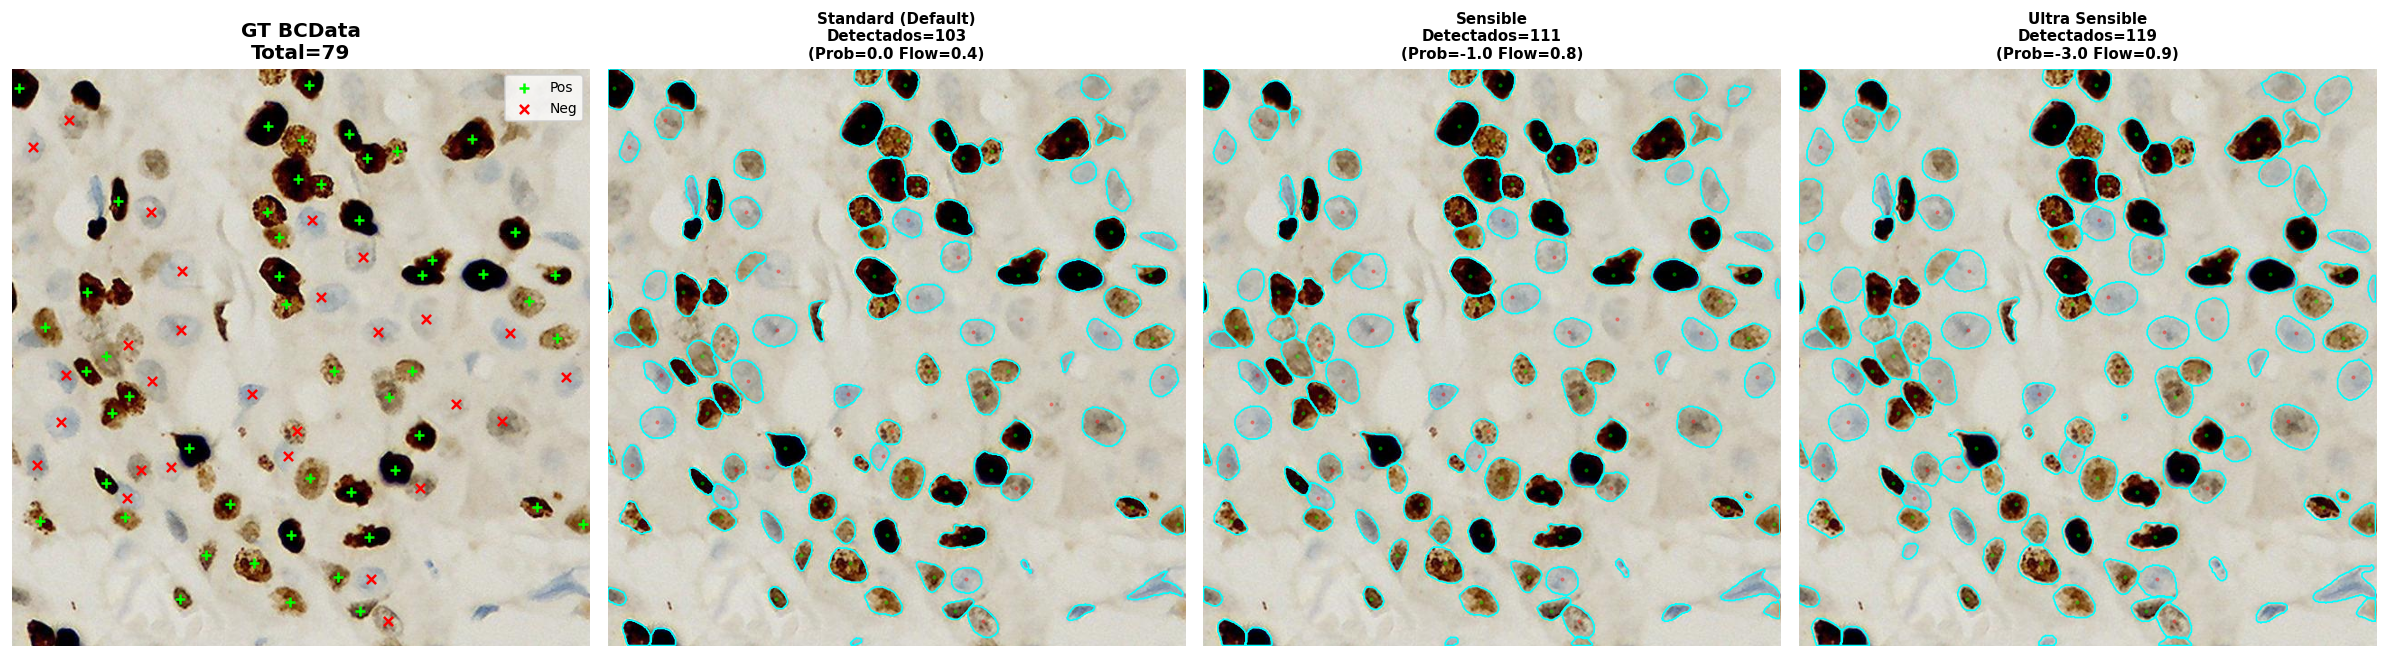

In [6]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
import warnings
import logging
from pathlib import Path

from cellpose import models, io, utils

BASE_ROOT = Path("/media/HDD2/BCData/BCData")
IMG_DIR = BASE_ROOT / "images/train"
GT_POS_DIR = BASE_ROOT / "annotations/train/positive"
GT_NEG_DIR = BASE_ROOT / "annotations/train/negative"

SELECTED_FILENAME = "0.png" 

MODEL_TYPE = 'cpsam'
GPU = True

DIAMETRO_ESTANDAR = 47

CONFIGURACIONES = [
    {'prob': 0.0,  'flow': 0.4, 'min': 20, 'desc': 'Standard (Default)'},
    {'prob': -1.0, 'flow': 0.8, 'min': 20, 'desc': 'Sensible'},
    {'prob': -3.0, 'flow': 0.9, 'min': 20,  'desc': 'Ultra Sensible'},
]


def load_gt_points_bcdata(img_path):
    """
    Carga Ground Truth desde archivos .h5 separados (Positive/Negative).
    Retorna dos arrays numpy: (pos_coords, neg_coords)
    """
    img_stem = img_path.stem 
    h5_name = f"{img_stem}.h5"
    
    pos_path = GT_POS_DIR / h5_name
    neg_path = GT_NEG_DIR / h5_name
    
    def extract_coords(path):
        if not path.exists(): return np.array([])
        try:
            with h5py.File(path, 'r') as f:
                if 'coordinates' in f.keys():
                    return np.asarray(f['coordinates'])
                elif 'coordinate' in f.keys():
                    return np.asarray(f['coordinate'])
        except Exception:
            return np.array([])
        return np.array([])

    pts_pos = extract_coords(pos_path)
    pts_neg = extract_coords(neg_path)
    
    return pts_pos, pts_neg

def visualizar_comparativa(img_path):
    print(f"Analizando: {img_path.name}")
    
    img = io.imread(str(img_path))
    if img is None: 
        print("Error cargando imagen.")
        return

    pts_pos, pts_neg = load_gt_points_bcdata(img_path)
    total_gt = len(pts_pos) + len(pts_neg)

    try:
        model = models.CellposeModel(gpu=GPU, pretrained_model=MODEL_TYPE)
    except Exception as e:
        print(f"Error cargando modelo: {e}")
        return

    n_cols = len(CONFIGURACIONES) + 1
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 6), dpi=120)

    axes[0].imshow(img)
    if len(pts_pos) > 0: axes[0].scatter(pts_pos[:, 0], pts_pos[:, 1], c='lime', marker='+', s=40, linewidths=1.5, label='Pos')
    if len(pts_neg) > 0: axes[0].scatter(pts_neg[:, 0], pts_neg[:, 1], c='red', marker='x', s=30, linewidths=1.5, label='Neg')
    axes[0].set_title(f"GT BCData\nTotal={total_gt}", fontweight='bold')
    axes[0].legend(loc='upper right', fontsize='small')
    axes[0].axis('off')

    for i, config in enumerate(CONFIGURACIONES):
        ax = axes[i + 1]
        
        masks, _, _ = model.eval(img, 
                                 diameter=DIAMETRO_ESTANDAR,
                                 invert=True, 
                                 cellprob_threshold=config['prob'],
                                 flow_threshold=config['flow'],
                                 min_size=config['min'])
        
        num_pred = masks.max()
        
        ax.imshow(img)
        
        outlines = utils.outlines_list(masks)
        for o in outlines:
            ax.plot(o[:, 0], o[:, 1], color='cyan', lw=1)
            
        if len(pts_pos) > 0: ax.scatter(pts_pos[:, 0], pts_pos[:, 1], c='lime', marker='.', s=10, alpha=0.3)
        if len(pts_neg) > 0: ax.scatter(pts_neg[:, 0], pts_neg[:, 1], c='red', marker='.', s=10, alpha=0.3)

        title = f"{config['desc']}\nDetectados={num_pred}"
        subtitle = f"(Prob={config['prob']} Flow={config['flow']})"
        ax.set_title(f"{title}\n{subtitle}", fontsize=9, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()
    
    del model
    torch.cuda.empty_cache()

target_path = IMG_DIR / SELECTED_FILENAME

if target_path.exists():
    print(f"Imagen objetivo encontrada: {SELECTED_FILENAME}")
    visualizar_comparativa(target_path)
else:
    print(f"NO SE ENCONTRÓ: {SELECTED_FILENAME}")
    print("   Buscando alternativas en la carpeta train...")
    
    test_files = sorted(list(IMG_DIR.glob("*.png")))
    if not test_files:
        test_files = sorted(list(IMG_DIR.glob("*.jpg")))
        
    if len(test_files) > 0:
        print(f"   🔄 Usando la primera disponible: {test_files[0].name}")
        visualizar_comparativa(test_files[0])
    else:
        print(f"No hay imágenes en {IMG_DIR}")